In [2]:
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import numpy as np
from itertools import product
import os
from ExtendedTSSRP import ExtendedTSSRP


from TSSRP import TSSRP
from MSSRP import MSSRP
# from adaptCUSUM import AdaptCUSUM
from spc import spc
import time
import pickle

data = io.loadmat('data/temperature.mat')
X_org = data['mMov0']
X = data['mMov1']
X = np.rollaxis(X,2,0)
X_org = np.rollaxis(X_org,2,0)
X.shape
nt,nx,ny = X.shape

In [3]:
nt,nx,ny 

(336, 71, 121)

In [4]:
np.mean(X[:50]*14),np.std(X[:50]*14),np.max(X[:50]*14)

(4.8919133520944165, 0.9873259878763835, 14.0)

In [5]:
X = X*14 
X = X - np.mean(X)

# Find the printing regions from the dataset 

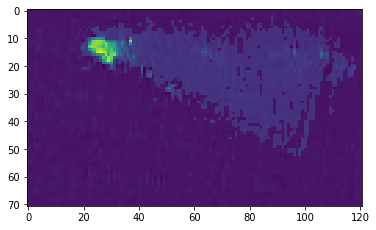

In [6]:
printingregion = np.sum(X_org,0)>30
defectregion = X[-100]
plt.imshow(printingregion+defectregion)

# Find the failure mode $M$ for that overlaps with the printing regions

In [14]:
from Bspline import bsplineBasis
kx = 20
ky = 30
degree = 2 # Overlap region? (Size of B-spline basis) 
Bx = bsplineBasis(nx,kx-degree+1,degree)
By = bsplineBasis(ny,ky-degree+1,degree)
Mall = np.kron(Bx,By)



In [15]:
Mall.shape

(8591, 600)

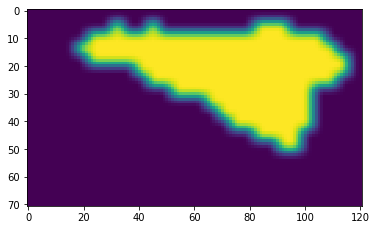

In [16]:
ii = []
MMregion = 0
for i in np.arange(Mall.shape[1]):
    mM = Mall[:,i].reshape(nx,ny)
    mMregion = mM > 0.1
    res = np.logical_and(mMregion,printingregion)
    if np.sum(res[:]) > 20:
        ii.append(i) 
        MMregion = MMregion + mM
M = Mall[:,ii]
plt.imshow(MMregion)

In [17]:
M.shape

(8591, 145)

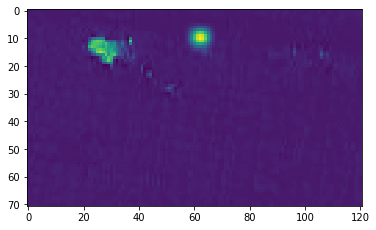

In [18]:
np.max(M)

plt.imshow(M[:,14].reshape(nx,ny)+defectregion*0.05)

In [58]:
p = nx*ny # Number of dimensions
c = 20 # Target meanshift is c * M
nsensors = 200 # Number of selected sensors
Ks = 25  #Select Top Ks control chart
k = M.shape[1]
T0 = 70
nmodels = 5
M_tssrp = np.kron(np.eye(p),np.ones((1,1))) # Mean Failure Modes
experiment_log = {'c':c, 'Ks':Ks, 'k0':k, 'degree':degree,'statistics':[],
                  'sens_history': [],
                  'mode_history':[],
                  'seq_stats': [] }
model_all = [[] for i in range(nmodels)]
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='random')
model_all[2] = ExtendedTSSRP(p, c, k,M,p,Ks,L=-1,chart = 'srp',mode='T2')
model_all[3] = TSSRP(p, c, p,M_tssrp,nsensors,nsensors,L=-1,chart='srp',mode='T2')
model_all[4] = MSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')

mumin = 1
#model_all[4]= AdaptCUSUM(p, c, p, M, nsensors, nsensors, mumin = mumin,delta=0.0002

MTSSRP
20.72410297393799


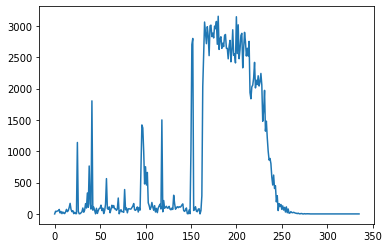

In [59]:
import time
start = time.time()
modelname = ['MTSSRP','Random','Oracle','TSSRP','AdaCUSUM']
# for i in range(nmodels):
for i in [0]:
    print(modelname[i])
    sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[i].compute_monitoring_statistics(X.reshape((nt,nx*ny)),T0,-1)
    experiment_log['statistics'].append( sequential_statistics_topRsum)
    experiment_log['sens_history'].append(sensor_selection_history)
    experiment_log['mode_history'].append(failure_mode_history)
    experiment_log['seq_stats'].append(sequential_statistics)
    plt.figure()
    plt.plot(sequential_statistics_topRsum)
    
end = time.time()
print(end - start)


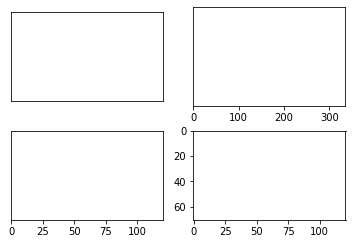

In [62]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera


fig, axes = plt.subplots(2,2)
camera = Camera(fig)
for t in range(250):
    axes[0,0].imshow(X[t],cmap=plt.get_cmap('hot'))
    axes[0,0].set_yticks([])
    axes[0,0].set_xticks([])
    axes[0,1].plot(sequential_statistics_topRsum[:t],'k-')
    axes[0,1].set(xlim=(0, nt), ylim=(0, 3000))
    axes[0,1].set_yticks([])
    axes[1,0].set_yticks([])
    S = np.zeros((nx*ny))
    S[sensor_selection_history[t].astype(int)] = 1
    mS = S.reshape(nx,ny)
    axes[1,0].imshow(mS,cmap=plt.get_cmap('hot'))

    axes[1,1].imshow(np.sum(M[:,failure_mode_history[t,0:10].astype(int)],axis=1).reshape(nx,ny))
    camera.snap()
animation = camera.animate()
animation.save('3D_original.mp4')

In [63]:
from IPython.display import Video

Video("3D_original.mp4")

In [40]:
M.shape

(8591, 145)